# Packages

In [37]:
import numpy as np 
import pandas as pd 
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

mpl.rcParams['figure.figsize'] = (16, 8)

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv


# Load Data

In [2]:
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv')

In [4]:
train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [5]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [7]:
test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


# EDA

In [8]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
daily_sales_per_store = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
daily_sales_per_item = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [9]:
daily_sales.head()

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


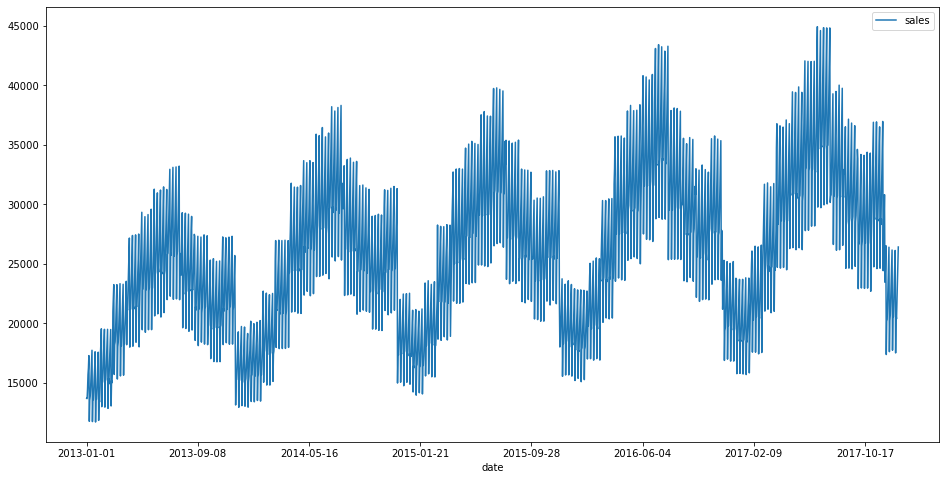

In [10]:
daily_sales.set_index(['date']).plot()

In [11]:
daily_sales_all_stores = pd.DataFrame()
daily_sales_all_stores['date'] = pd.date_range(start= '2013-01-01', end='2017-12-31', freq='d')
for store in daily_sales_per_store['store'].unique():
    daily_sales_all_stores[store] = daily_sales_per_store[daily_sales_per_store['store'] == store]['sales'].values

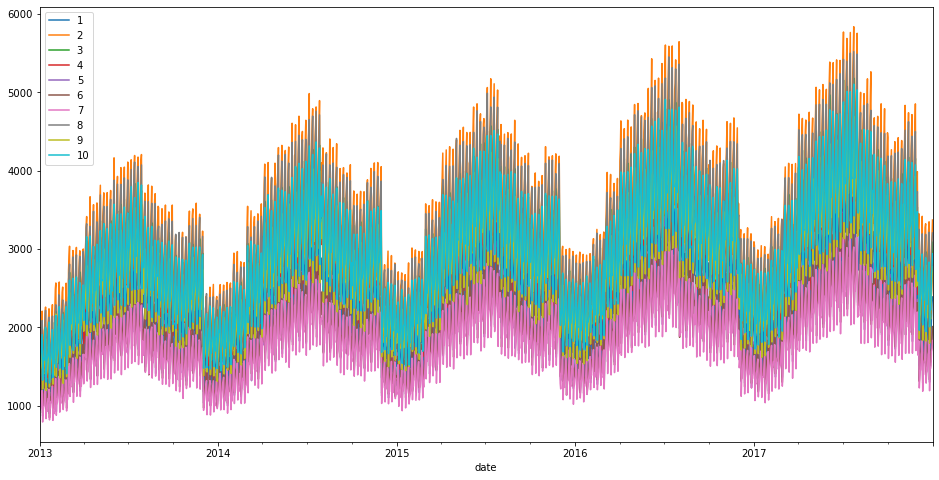

In [12]:
daily_sales_all_stores.set_index(['date']).plot()

In [13]:
daily_sales_all_items = pd.DataFrame()
daily_sales_all_items['date'] = pd.date_range(start= '2013-01-01', end='2017-12-31', freq='d')
for item in daily_sales_per_item['item'].unique():
    daily_sales_all_items[item] = daily_sales_per_item[daily_sales_per_item['item'] == item]['sales'].values

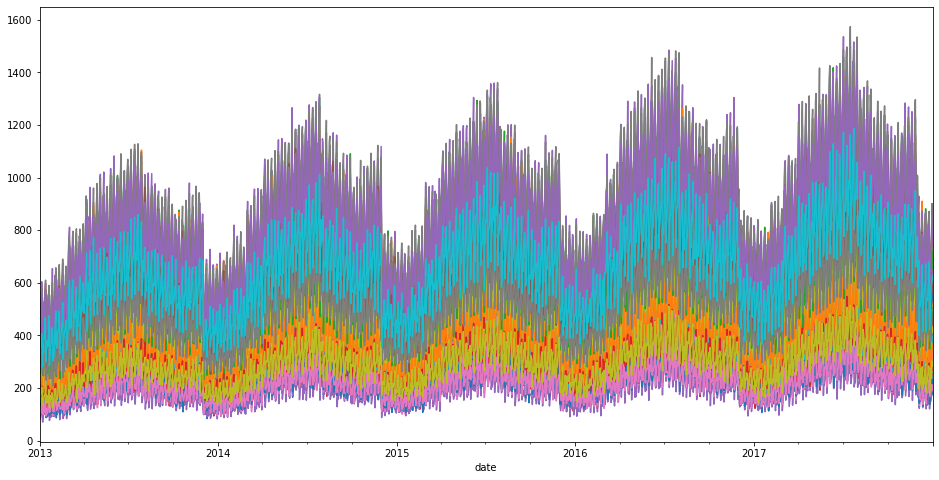

In [14]:
daily_sales_all_items.set_index(['date']).plot(legend=None)

# Data Preparation

The model will be given the last 30 values (1 month) and needs to learn to forecast the following 90 values (3 months, which corresponds to the length of the test data)

In [15]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [16]:
df = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
df = df.agg({'sales':['mean']})
df = df.drop('date', axis=1)
df.columns = ['item', 'store', 'sales']
df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,item,store,sales
0,1,1,13
1,1,1,11
2,1,1,14
3,1,1,13
4,1,1,10


In [17]:
# 80% Train, 20% Validation
TRAIN_SPLIT = 730400 

data = df.values

#Standardize the data
scaler = StandardScaler()
scaler.fit(data[:TRAIN_SPLIT])
data = scaler.transform(data)

In [18]:
past_history = 30
future_target = 90
STEP = 1

x_train, y_train = multivariate_data(data, data[:, 2], 0,
                                    TRAIN_SPLIT, past_history,
                                    future_target, STEP)
x_val, y_val = multivariate_data(data, data[:, 2],
                                TRAIN_SPLIT, None, past_history,
                                future_target, STEP)

# Model

In [20]:
def plot_train_history(history, title):
    loss = history.history['loss']
    mae = history.history['mae']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, mae, 'r', label='MAE')
    plt.title(title)
    plt.legend()

    plt.show()

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=x_train.shape[-2:]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(16, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(90)
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            512       
_________________________________________________________________
lstm (LSTM)                  (None, 30, 32)            8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 90)                2970      
Total params: 21,210
Trainable params: 21,210
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

history = model.fit(x_train, y_train, batch_size=256, epochs=10)

Epoch 1/10
2854/2854 [==============================] - 183s 64ms/step - loss: 0.1281 - mae: 0.3858
Epoch 2/10
2854/2854 [==============================] - 177s 62ms/step - loss: 0.0990 - mae: 0.3356
Epoch 3/10
2854/2854 [==============================] - 181s 64ms/step - loss: 0.0932 - mae: 0.3241
Epoch 4/10
2854/2854 [==============================] - 179s 63ms/step - loss: 0.0902 - mae: 0.3181
Epoch 5/10
2854/2854 [==============================] - 182s 64ms/step - loss: 0.0885 - mae: 0.3144
Epoch 6/10
2854/2854 [==============================] - 185s 65ms/step - loss: 0.0868 - mae: 0.3110
Epoch 7/10
2854/2854 [==============================] - 185s 65ms/step - loss: 0.0854 - mae: 0.3080
Epoch 8/10
2854/2854 [==============================] - 183s 64ms/step - loss: 0.0837 - mae: 0.3049
Epoch 9/10
2854/2854 [==============================] - 182s 64ms/step - loss: 0.0823 - mae: 0.3022
Epoch 10/10
2854/2854 [==============================] - 183s 64ms/step - loss: 0.0815 - mae: 0.3006

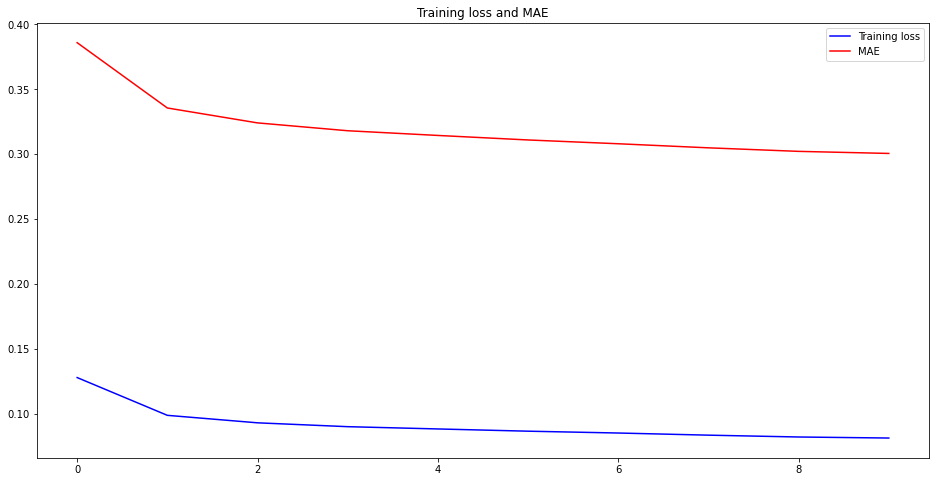

In [22]:
plot_train_history(history, 'Training loss and MAE')

In [23]:
model.evaluate(x_val, y_val)

5703/5703 [==============================] - 55s 10ms/step - loss: 0.0936 - mae: 0.3227


[0.09360666573047638, 0.3226620852947235]

In [24]:
y_pred = model.predict(x_val)
rmse = sqrt(mean_squared_error(y_val, y_pred))
print("Val RMSE: {}".format(rmse))

# Save Model

In [36]:
model.save('./item_demand_forecasting_lstm.h5')
scaler_file = './item_demand_forecasting_scaler.sav'
pickle.dump(scaler, open(scaler_file, 'wb'))